# 🧠 Explainable Transformer-Based Multi-Label Toxic Comment Classification

### 📘 Project Overview
This project aims to build an **explainable transformer-based model** for detecting multiple types of toxic online comments using the **Jigsaw Toxic Comment Classification Challenge** dataset.  
Each comment can belong to one or more categories — *toxic*, *severe_toxic*, *obscene*, *threat*, *insult*, and *identity_hate*.

### 🎯 Objectives
- Develop a **multi-label classification model** using a pre-trained transformer (DistilBERT).  
- Apply **data cleaning**, **multi-label stratified splitting**, and **fine-tuning** with early stopping.  
- Evaluate performance using **macro F1**, **precision**, **recall**, and **ROC-AUC**.  
- Provide **explainable AI insights** through token-level attributions with Captum Integrated Gradients.

### ⚙️ Workflow
1. **Data Cleaning & Preprocessing** – normalization, deduplication, and stratified splits.  
2. **Tokenization & Model Definition** – transformer backbone with a multi-label head.  
3. **Training & Evaluation** – fine-tuning with custom metrics and threshold tuning.  
4. **Explainability** – visualize influential words per predicted label.

### 🧩 Tools
`PyTorch`, `Transformers`, `scikit-learn`, `Captum`, `nltk`, `WordCloud`, `iterative-stratification`.

---

> This notebook presents a **complete, step-by-step workflow** — from text cleaning and transformer fine-tuning to explainable multi-label toxicity detection.


# Step 1 : 🧩 Environment Setup

In [1]:
# # ============================================
# # 🧩 Environment Setup — Kaggle 
# # ============================================
# # Rationale:
# # - Avoids version/ABI conflicts (Arrow + HuggingFace)
# # - Makes environment reproducible
# # - Must run BEFORE any imports

# !pip -q install iterative-stratification  # for proper multi-label stratified split
# !pip -q uninstall -y pyarrow
# !pip -q install -U \
#   "pyarrow>=14,<20" \
#   "datasets==3.0.1" \
#   "transformers>=4.44" \
#   "accelerate>=0.34" \
#   "scikit-learn<1.7" 

# print("✅ Environment prepared. Please RESTART the runtime once (Runtime -> Restart) before running the next cells.")


In [2]:
import sys, torch, transformers, datasets, pyarrow
print("Python:", sys.version.split()[0])
print("Torch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())
print("Transformers:", transformers.__version__)
print("Datasets:", datasets.__version__)
print("PyArrow:", pyarrow.__version__)


Python: 3.11.13
Torch: 2.6.0+cu124 | CUDA available: True
Transformers: 4.52.4
Datasets: 3.6.0
PyArrow: 19.0.1


# Step 2 : Import the dataset and show the its summary

In [3]:
# ==========================================
# Load + minimal clean + quick diagnostics
# ==========================================

# Optional installs (no-op if already present in the environment)
!pip -q install iterative-stratification
!pip -q install ftfy

import os, random, re, html
import numpy as np
import pandas as pd
import torch
from ftfy import fix_text  # imported but intentionally NOT used to keep logic identical

# -------------------------------
# Reproducibility (fixed seed)
# -------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# -------------------------------
# Paths / constants
# -------------------------------
DATA_DIR  = "/kaggle/input/jigsaw-toxic-comment-classification-challenge"
WORK_DIR  = "/kaggle/working"
SPLIT_DIR = f"{WORK_DIR}/splits"; os.makedirs(SPLIT_DIR, exist_ok=True)

# Label order is critical for multi-label tasks—do not change
LABELS = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# -------------------------------
# Load raw data
# -------------------------------
IN_PATH = f"{DATA_DIR}/train.csv"
df = pd.read_csv(IN_PATH)

# -------------------------------
# Minimal cleaning
# - Keep natural casing/punctuation (good for Transformer tokenizers)
# - Only guarantee non-null text
# -------------------------------
df["comment_text"] = df["comment_text"].fillna("")

# -------------------------------
# Schema checks (fail fast if columns missing)
# -------------------------------
assert "comment_text" in df.columns, "Missing column: comment_text"
for col in LABELS:
    assert col in df.columns, f"Missing label column: {col}"

# -------------------------------
# Quick diagnostics
# - Label prevalence = mean of 0/1 per label
# - Multi-label intensity = number of positive labels per comment
# -------------------------------
n_rows = len(df)
label_means = df[LABELS].mean().sort_values(ascending=False)

# Create once, reuse; this column is only for the diagnostic print below
df["labels_sum"] = df[LABELS].sum(axis=1)
labels_sum_counts = df["labels_sum"].value_counts().sort_index()

# -------------------------------
# Printout
# -------------------------------
print(f"Rows: {n_rows}")

print("\nLabel prevalence (mean of 0/1):")
print(label_means.round(4))

print("\nLabels per comment (value counts):")
print(labels_sum_counts)

# - The dataframe `df` is ready for downstream steps (splitting, tokenization, etc.).


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.9 MB/s eta 0:00:00
Rows: 159571

Label prevalence (mean of 0/1):
toxic            0.0958
obscene          0.0529
insult           0.0494
severe_toxic     0.0100
identity_hate    0.0088
threat           0.0030
dtype: float64

Labels per comment (value counts):
labels_sum
0    143346
1      6360
2      3480
3      4209
4      1760
5       385
6        31
Name: count, dtype: int64


In [4]:
df.head(5)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,labels_sum
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


# Step 3 : Data cleaning 

In [5]:
# ==========================================
# Clean Jigsaw train.csv
# ==========================================
import os, re, html
import pandas as pd
from ftfy import fix_text  # used to repair mojibake (e.g., Â, â€”)

# -----------------------------
# Paths / constants
# -----------------------------
DATA_DIR  = "/kaggle/input/jigsaw-toxic-comment-classification-challenge"
IN_PATH   = f"{DATA_DIR}/train.csv"
OUT_DIR   = "/kaggle/working/clean"
LABELS    = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

# -----------------------------
# Load raw CSV
# -----------------------------
df0 = pd.read_csv(IN_PATH)
n0  = len(df0)

# -----------------------------
# 1) Ensure text is string
#    (keep natural casing/punctuation for Transformer tokenizers)
# -----------------------------
df0["comment_text"] = df0["comment_text"].astype(str)

# -----------------------------
# 2) Normalize encoding/HTML/whitespace
#    - fix_text: repairs mojibake
#    - html.unescape: &amp; -> &
#    - newline + whitespace normalization
# -----------------------------
def normalize_text(s: str) -> str:
    s = fix_text(s)                # repair mojibake (Â, â€”, etc.)
    s = html.unescape(s)           # decode HTML entities
    s = s.replace("\r\n", "\n")    # standardize newlines
    s = re.sub(r"\s+", " ", s)     # collapse whitespace/newlines
    return s.strip()

df0["comment_text"] = df0["comment_text"].map(normalize_text)

# -----------------------------
# 3) Drop rows that are empty after normalization
# -----------------------------
df = df0[df0["comment_text"].str.len() > 0].copy()
empties_dropped = n0 - len(df)

# -----------------------------
# 4) Coerce label columns to {0,1}
# -----------------------------
for c in LABELS:
    df[c] = (df[c].fillna(0).astype(int) > 0).astype(int)

# -----------------------------
# 5) Deduplicate exact same text
#    - If duplicates disagree on labels, take OR (max)
#    - Preserve 'id' if present (first)
# -----------------------------
before_dups = len(df)
agg = {c: "max" for c in LABELS}
keep_cols = ["id"] if "id" in df.columns else []
clean = (
    df.sort_values(keep_cols + ["comment_text"])
      .groupby("comment_text", as_index=False)
      .agg({**{k: "first" for k in keep_cols}, **agg})
)
dups_dropped = before_dups - len(clean)

# -----------------------------
# 6) Strip ASCII control characters
#    (keep punctuation/emojis intact)
# -----------------------------
clean["comment_text"] = clean["comment_text"].str.replace(
    r"[\u0000-\u0008\u000B\u000C\u000E-\u001F\u007F]", "", regex=True
)

# -----------------------------
# 7) Save cleaned CSV
# -----------------------------
os.makedirs(OUT_DIR, exist_ok=True)
CLEAN_PATH = f"{OUT_DIR}/train_clean.csv"
clean.to_csv(CLEAN_PATH, index=False)

# -----------------------------
# Console summary (polished)
# -----------------------------
print("=== Data Cleaning Summary ===")
print(f"Rows original:        {n0:,}")
print(f"Empties dropped:      {empties_dropped:,}")
print(f"Duplicates removed:   {dups_dropped:,}")
print(f"Rows after cleaning:  {len(clean):,}\n")

prev = (
    clean[LABELS]
    .mean()
    .sort_values(ascending=False)
    .round(4)
    .rename("prevalence")
    .to_frame()
)
print("Label prevalence after cleaning:")
print(prev)
print(f"\nSaved: {CLEAN_PATH}")


=== Data Cleaning Summary ===
Rows original:        159,571
Empties dropped:      0
Duplicates removed:   198
Rows after cleaning:  159,373

Label prevalence after cleaning:
               prevalence
toxic              0.0958
obscene            0.0529
insult             0.0493
severe_toxic       0.0100
identity_hate      0.0088
threat             0.0030

Saved: /kaggle/working/clean/train_clean.csv


# Step 4 : Show word distribution in each comment

=== Word Count Summary ===
Total comments:       159,373
Average word count:   67.26
Median word count:    36.00
Maximum word count:   1,411


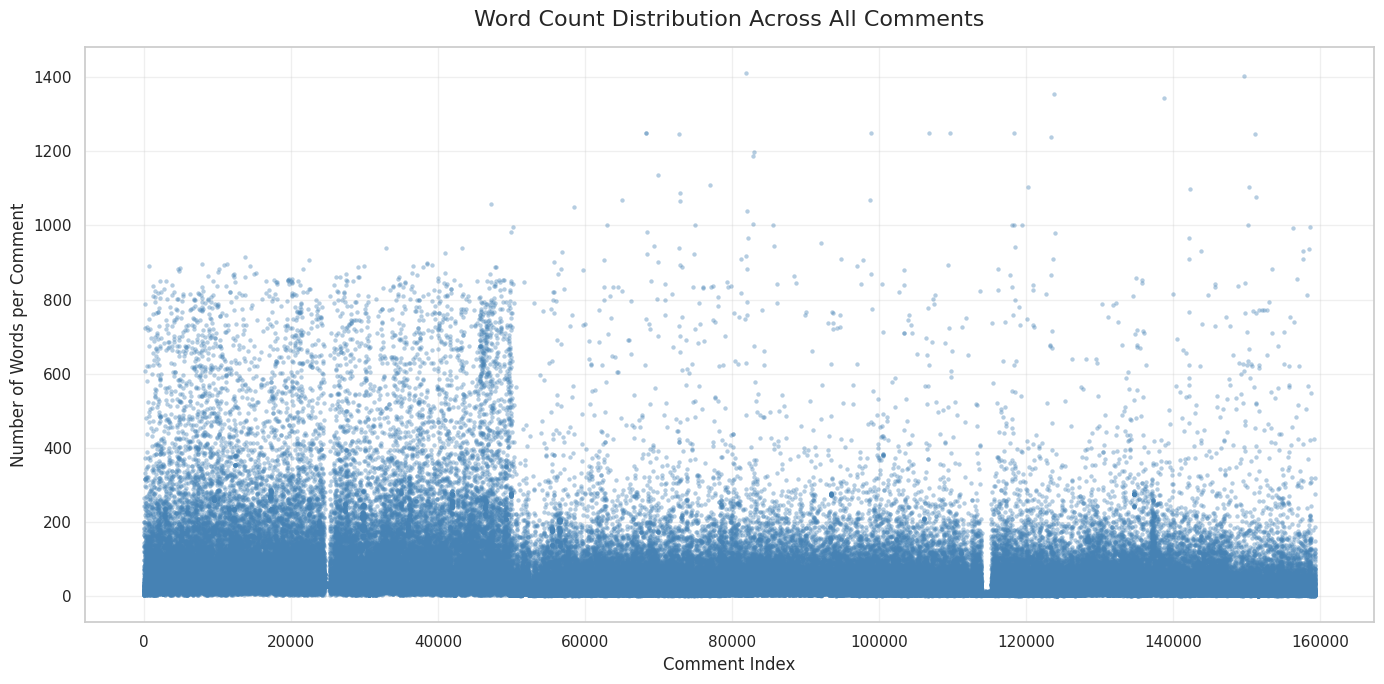

In [6]:
# ==========================================
# 📊 Word Count Distribution — Seaborn Scatterplot
# ==========================================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# Load cleaned dataset
# -----------------------------
df = pd.read_csv("/kaggle/working/clean/train_clean.csv")

# -----------------------------
# 1️⃣ Compute per-comment word count
# -----------------------------
df["word_count"] = df["comment_text"].apply(lambda x: len(str(x).split()))

# -----------------------------
# 2️⃣ Display basic statistics
# -----------------------------
print("=== Word Count Summary ===")
print(f"Total comments:       {len(df):,}")
print(f"Average word count:   {df['word_count'].mean():.2f}")
print(f"Median word count:    {df['word_count'].median():.2f}")
print(f"Maximum word count:   {df['word_count'].max():,}")

# -----------------------------
# 3️⃣ Visualization setup (Seaborn scatter)
#     - Each point = one comment
#     - y-axis = number of words
#     - x-axis = comment index (proxy for dataset order)
# -----------------------------
sns.set(style="whitegrid", context="notebook")

plt.figure(figsize=(14, 7))
sns.scatterplot(
    data=df,
    x=df.index,
    y="word_count",
    color="steelblue",
    alpha=0.4,    # slight transparency for dense regions
    s=10,         # small point size for better distribution visibility
    linewidth=0
)

# -----------------------------
# 4️⃣ Titles, labels, and formatting
# -----------------------------
plt.title("Word Count Distribution Across All Comments", fontsize=16, pad=15)
plt.xlabel("Comment Index", fontsize=12)
plt.ylabel("Number of Words per Comment", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Step 4B : Labels based Word cloud

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


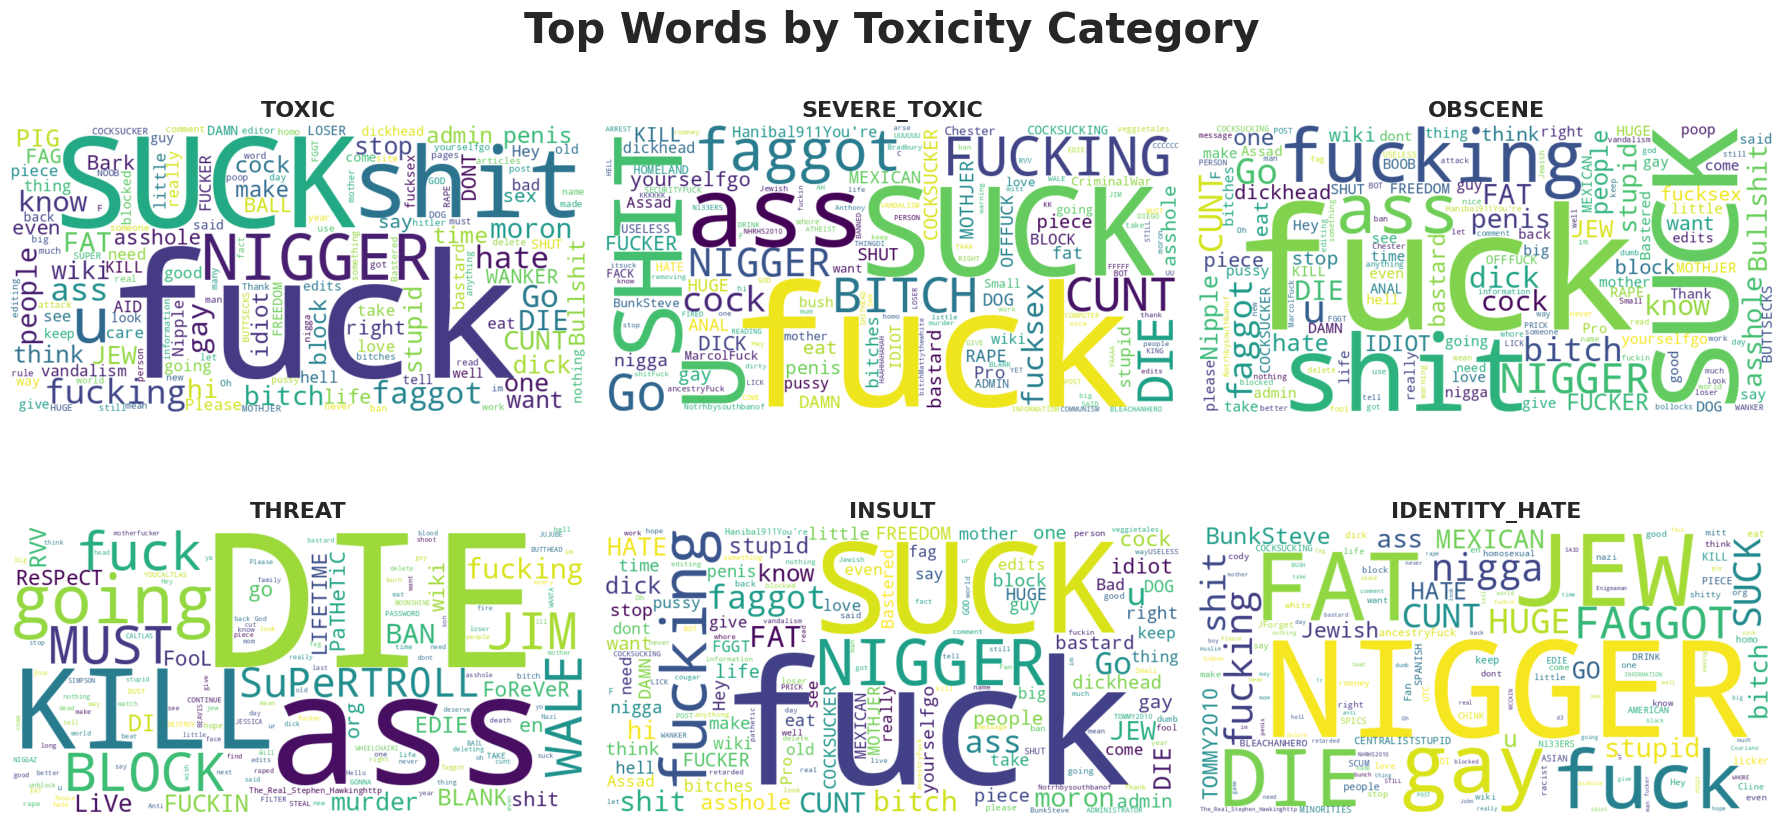

In [7]:
# =========================================================
# Generate per-label WordClouds (Toxic Comment Dataset)
# =========================================================
# Purpose:
# - Visualize the most frequent words associated with each toxicity label.
# - Helps understand common patterns or linguistic cues per class.
# =========================================================

# --- Install dependencies quietly (only first run) ---
# !pip install -q wordcloud nltk

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# =========================================================
# 1️⃣ Load pre-cleaned dataset
# =========================================================
DATA_PATH = "/kaggle/working/clean/train_clean.csv"
df = pd.read_csv(DATA_PATH)

# =========================================================
# 2️⃣ Define stopwords (common words to exclude)
# =========================================================
# Combine NLTK stopwords + WordCloud defaults
custom_stopwords = set(stopwords.words("english")) | set(STOPWORDS)

# Add dataset-specific neutral terms that dominate comments but carry no meaning
custom_stopwords |= {"article", "page", "wikipedia", "edit", "source", "user", "talk"}

# =========================================================
# 3️⃣ Define toxicity labels
# =========================================================
LABELS = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# =========================================================
# 4️⃣ Generate a WordCloud for each label
# =========================================================
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, label in enumerate(LABELS):
    # Extract all comments labeled with this class
    subset = df[df[label] == 1]["comment_text"].astype(str)

    # Join all comments into one large string
    text = " ".join(subset.tolist())

    # Create WordCloud
    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        stopwords=custom_stopwords,
        collocations=False,    # avoid merging frequent bigrams
        max_words=150
    ).generate(text)

    # --- Plot ---
    axes[i].imshow(wc, interpolation="bilinear")
    axes[i].set_title(label.upper(), fontsize=16, fontweight="bold")
    axes[i].axis("off")

# =========================================================
# 5️⃣ Finalize visualization
# =========================================================
plt.suptitle("Top Words by Toxicity Category", fontsize=30, fontweight="bold", y=0.93)
plt.tight_layout()
plt.show()


# Step 4C : Combined word cloud

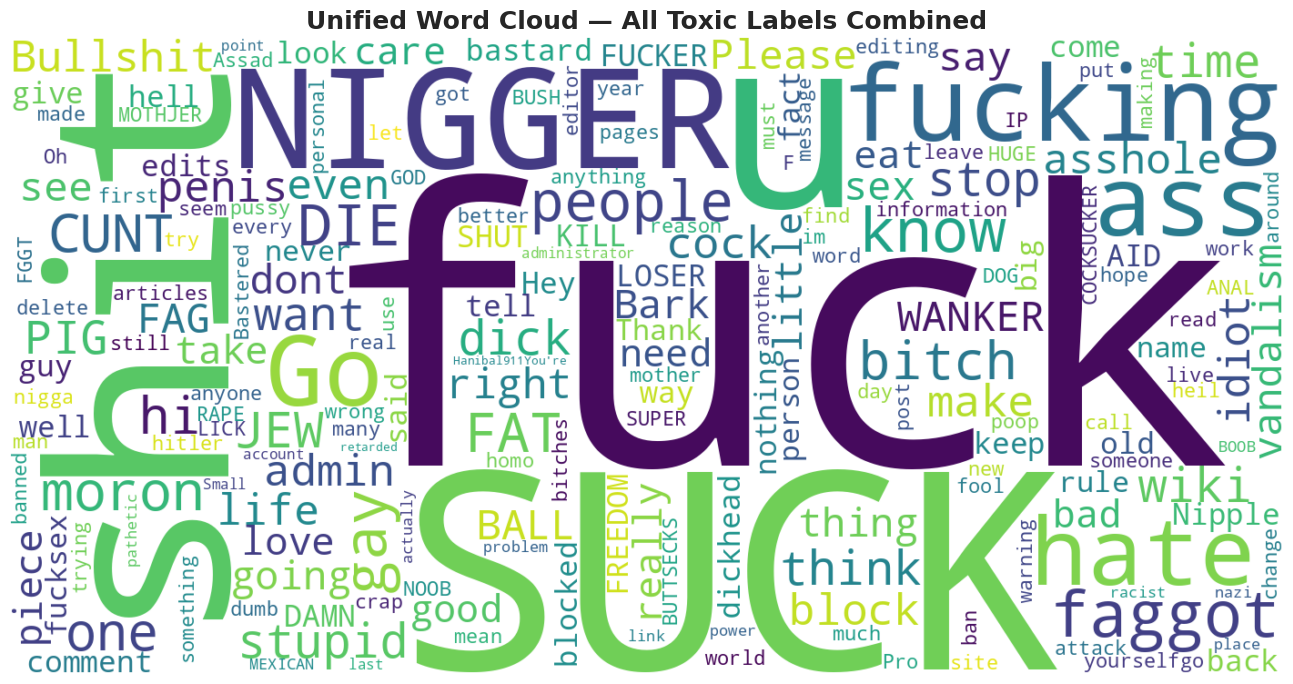

In [8]:
# =========================================================
# Unified Word Cloud — All Toxic Labels Combined
# =========================================================
# Purpose:
# - Combine all comments that have *any* toxic label.
# - Generate a single WordCloud to visualize overall vocabulary patterns.
# =========================================================

# --- Imports ---
from wordcloud import WordCloud, STOPWORDS
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

# =========================================================
# 1️⃣ Load cleaned dataset
# =========================================================
DATA_PATH = "/kaggle/working/clean/train_clean.csv"
df = pd.read_csv(DATA_PATH)

# Define all target labels (must match training)
LABELS = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# =========================================================
# 2️⃣ Select all comments that contain at least one toxic label
# =========================================================
# Sum of label columns > 0 means the comment has at least one toxic category
toxic_all = df[df[LABELS].sum(axis=1) > 0]["comment_text"].astype(str)

# Join all toxic comments into a single text corpus
text_all = " ".join(toxic_all.tolist())

# =========================================================
# 3️⃣ Define stopwords (to exclude common, meaningless words)
# =========================================================
# Combine WordCloud and NLTK English stopwords
custom_stopwords = set(stopwords.words("english")) | set(STOPWORDS)

# Add dataset-specific neutral/frequent terms to remove (Wikipedia-origin noise)
custom_stopwords |= {"article", "page", "wikipedia", "edit", "source", "user", "talk"}

# =========================================================
# 4️⃣ Generate the unified WordCloud
# =========================================================
wc = WordCloud(
    width=1400, height=700,
    background_color="white",
    stopwords=custom_stopwords,
    collocations=False,   # treat repeated words independently
    max_words=200         # top N frequent tokens to display
).generate(text_all)

# =========================================================
# 5️⃣ Plot the result
# =========================================================
plt.figure(figsize=(14, 7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Unified Word Cloud — All Toxic Labels Combined", fontsize=18, fontweight="bold")
plt.tight_layout()
plt.show()


# Step 5: Dataset splitting

In [9]:
# =========================================================
# Multi-label Stratified Split (80/10/10) 
# =========================================================
# Purpose:
# - Create train/valid/test splits that preserve per-label prevalence
# - Ensure splits are disjoint (no ID leakage)
# - Save CSVs for downstream modeling
# =========================================================

import os
import numpy as np
import pandas as pd
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

# ---------------------------
# Config
# ---------------------------
SEED = 42
SPLIT_DIR = "/kaggle/working/splits"; os.makedirs(SPLIT_DIR, exist_ok=True)
LABELS = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

# ---------------------------
# Load cleaned data
# ---------------------------
clean = pd.read_csv("/kaggle/working/clean/train_clean.csv")

# Ensure a unique ID column to verify disjointness across splits
id_col = "id" if "id" in clean.columns else None
if id_col is None:
    clean["id"] = np.arange(len(clean))
    id_col = "id"

# Features/labels for stratification
X = clean[[id_col, "comment_text"]]
Y = clean[LABELS].values

# ---------------------------
# First split: 80% train, 20% temp
# ---------------------------
m1 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx, temp_idx = next(m1.split(X, Y))
train_df = clean.iloc[train_idx].reset_index(drop=True)
temp_df  = clean.iloc[temp_idx].reset_index(drop=True)

# ---------------------------
# Second split: temp -> 10% valid, 10% test
# (i.e., 50/50 split of the 20% temp)
# ---------------------------
m2 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=SEED)
val_idx, test_idx = next(m2.split(temp_df[[id_col, "comment_text"]], temp_df[LABELS].values))
val_df  = temp_df.iloc[val_idx].reset_index(drop=True)
test_df = temp_df.iloc[test_idx].reset_index(drop=True)

# ---------------------------
# Sanity check: no leakage across splits
# ---------------------------
s_train, s_val, s_test = set(train_df[id_col]), set(val_df[id_col]), set(test_df[id_col])
assert s_train.isdisjoint(s_val) and s_train.isdisjoint(s_test) and s_val.isdisjoint(s_test), "Split leakage detected!"

# ---------------------------
# Pretty prevalence print helper
# ---------------------------
def prev(name: str, d: pd.DataFrame) -> str:
    m = d[LABELS].mean().round(4).to_dict()
    return f"{name}: n={len(d)} | " + ", ".join(f"{k}:{v:.4f}" for k, v in m.items())

print(prev("train", train_df))
print(prev("valid", val_df))
print(prev("test ", test_df))

# ---------------------------
# Save splits (same columns as input + labels)
# ---------------------------
cols = [id_col, "comment_text"] + LABELS
train_df[cols].to_csv(f"{SPLIT_DIR}/train.csv", index=False)
val_df[cols].to_csv(f"{SPLIT_DIR}/valid.csv", index=False)
test_df[cols].to_csv(f"{SPLIT_DIR}/test.csv", index=False)

print("Saved:")
print(f"{SPLIT_DIR}/train.csv")
print(f"{SPLIT_DIR}/valid.csv")
print(f"{SPLIT_DIR}/test.csv")


train: n=127498 | toxic:0.0958, severe_toxic:0.0100, obscene:0.0529, threat:0.0030, insult:0.0493, identity_hate:0.0088
valid: n=15937 | toxic:0.0958, severe_toxic:0.0100, obscene:0.0529, threat:0.0029, insult:0.0493, identity_hate:0.0088
test : n=15938 | toxic:0.0958, severe_toxic:0.0100, obscene:0.0530, threat:0.0030, insult:0.0494, identity_hate:0.0088
Saved:
/kaggle/working/splits/train.csv
/kaggle/working/splits/valid.csv
/kaggle/working/splits/test.csv


# Step 6 : Set config

In [10]:
# =========================================================
# Setup: constants, seeds, and basic config (exact logic)
# =========================================================

# --- Standard libs ---
import os
import json  # saving/loading configs (thresholds, metrics)
import random

# --- Numerical / ML libs ---
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_fscore_support
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, TrainingArguments, Trainer

# ---------------------------
# Reproducibility
# ---------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ---------------------------
# Paths
# ---------------------------
SPLIT_DIR = "/kaggle/working/splits"         # where train/valid/test CSVs live
OUT_DIR   = "/kaggle/working/artifacts"      # where models/metrics will be saved
os.makedirs(OUT_DIR, exist_ok=True)

# ---------------------------
# Labels (order must remain consistent everywhere)
# ---------------------------
LABELS = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# ---------------------------
# Model configuration
# ---------------------------
MODEL_NAME   = "distilbert-base-uncased"  # can swap later (e.g., "roberta-base")
MAX_LENGTH   = 256                        # tokenizer truncation length
TRAIN_BS     = 16                         # per-device train batch size
EVAL_BS      = 32                         # per-device eval batch size
EPOCHS       = 3                          # training epochs
LR           = 2e-5                       # learning rate
WEIGHT_DECAY = 0.05                       # L2 weight decay

# ---------------------------
# Device selection
# ---------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


2025-10-15 16:18:03.990880: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760545084.189984      78 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760545084.242174      78 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Device: cuda


# Step 7 : Load splits and tokenize

In [11]:
# =========================================================
# Step: Load Stratified Splits + Tokenization
# =========================================================
# Purpose:
# - Load the pre-split cleaned CSVs (train/valid/test)
# - Convert them into Hugging Face Datasets
# - Tokenize text while preserving multi-label targets
# =========================================================

import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

# ---------------------------
# 1️⃣ Load the stratified splits
# ---------------------------
train_df = pd.read_csv(f"{SPLIT_DIR}/train.csv")
valid_df = pd.read_csv(f"{SPLIT_DIR}/valid.csv")
test_df  = pd.read_csv(f"{SPLIT_DIR}/test.csv")

# Sanity check: ensure all expected columns are present
for col in ["comment_text", *LABELS]:
    assert col in train_df.columns, f"Missing column: {col}"

# ---------------------------
# 2️⃣ Convert to Hugging Face DatasetDict
# ---------------------------
ds = DatasetDict({
    "train": Dataset.from_pandas(train_df, preserve_index=False),
    "validation": Dataset.from_pandas(valid_df, preserve_index=False),
    "test": Dataset.from_pandas(test_df, preserve_index=False),
})

# ---------------------------
# 3️⃣ Load tokenizer (fast implementation)
# ---------------------------
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

# ---------------------------
# 4️⃣ Tokenization function
# ---------------------------
def encode_batch(example):
    """
    Tokenize a single comment and attach its multi-label targets.

    Notes:
    - Keeps text casing and punctuation (BERT prefers natural text).
    - Creates a fixed-order label vector aligned with LABELS.
    """
    enc = tok(
        example["comment_text"],
        truncation=True,
        padding=False,
        max_length=MAX_LENGTH,
    )
    enc["labels"] = [example[label] for label in LABELS]
    return enc

# ---------------------------
# 5️⃣ Apply tokenization to all splits
# ---------------------------
cols_to_remove = [c for c in train_df.columns if c not in ["comment_text", *LABELS]]

ds_tok = ds.map(
    encode_batch,
    remove_columns=cols_to_remove,
    desc="Tokenizing dataset"
)

print(ds_tok)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing dataset:   0%|          | 0/127498 [00:00<?, ? examples/s]

Tokenizing dataset:   0%|          | 0/15937 [00:00<?, ? examples/s]

Tokenizing dataset:   0%|          | 0/15938 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 127498
    })
    validation: Dataset({
        features: ['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 15937
    })
    test: Dataset({
        features: ['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 15938
    })
})


# Step 8 : Define the model (PyTorch, multi-label head)

In [12]:
# =========================================================
# Model Definition: Transformer-based Multi-Label Classifier
# =========================================================
# Purpose:
# - Build a DistilBERT/RoBERTa backbone for toxic comment classification.
# - Use a single linear layer to predict all 6 labels simultaneously.
# - Apply BCEWithLogitsLoss (sigmoid + binary cross-entropy).
# =========================================================

import torch
import torch.nn as nn
from transformers import AutoModel

# ---------------------------
# Model Architecture
# ---------------------------
class ToxicMultiLabel(nn.Module):
    """
    Multi-label toxic comment classifier.

    Notes:
    - The backbone is a pretrained Transformer encoder (e.g., DistilBERT).
    - The classification head outputs one logit per label (no softmax).
    - Loss function: BCEWithLogitsLoss (handles multi-label classification).
    """

    def __init__(self, model_name: str, num_labels: int):
        super().__init__()
        # Load pretrained Transformer backbone
        self.backbone = AutoModel.from_pretrained(model_name)
        hidden = self.backbone.config.hidden_size

        # Dropout regularization (reduces overfitting)
        self.dropout = nn.Dropout(0.5)

        # Classification head — one neuron per label
        self.classifier = nn.Linear(hidden, num_labels)

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        """
        Forward pass through Transformer + classification head.
        Returns:
            - logits: raw outputs (one per label)
            - loss: BCE loss (if labels provided)
        """
        # Extract last hidden states from the Transformer
        out = self.backbone(input_ids=input_ids, attention_mask=attention_mask)

        # Use the [CLS]-like embedding (first token) as sentence representation
        cls_token = out.last_hidden_state[:, 0]

        # Apply dropout + classification layer
        logits = self.classifier(self.dropout(cls_token))

        # Compute loss if labels are provided (used during training)
        loss = None
        if labels is not None:
            loss = nn.BCEWithLogitsLoss()(logits, labels.float())

        return {"loss": loss, "logits": logits}


# ---------------------------
# Instantiate Model
# ---------------------------
num_labels = len(LABELS)
model = ToxicMultiLabel(MODEL_NAME, num_labels).to(DEVICE)

print(f"✅ Model initialized — Backbone: {MODEL_NAME}, Labels: {num_labels}, Device: {DEVICE}")


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

✅ Model initialized — Backbone: distilbert-base-uncased, Labels: 6, Device: cuda


# Step 9 : Train the Model, evaluate, and save artifacts

In [13]:
# =========================================================
# Training setup: metrics, collator, arguments, Trainer
# (Exact behavior preserved; comments clarified)
# =========================================================

from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
import torch

# ---------------------------------
# Metric function for multi-label
# ---------------------------------
def compute_metrics(eval_pred):
    """
    Converts logits -> probabilities via sigmoid, thresholds at 0.5,
    and reports macro-averaged metrics across labels.

    Notes:
      - Thresholds are fixed at 0.5 here; you can tune per-label thresholds
        later using the validation set and re-evaluate.
      - `zero_division=0` avoids warnings when a label has no positives.
    """
    logits, labels = eval_pred                                # shapes: (N, L), (N, L)
    probs = 1.0 / (1.0 + np.exp(-logits))                     # sigmoid
    preds = (probs >= 0.5).astype(int)                        # fixed threshold

    f1 = f1_score(labels, preds, average="macro", zero_division=0)
    pr, rc, _, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )
    try:
        auc = roc_auc_score(labels, probs, average="macro")   # uses probabilities
    except ValueError:
        # If a label has only one class present, ROC-AUC is undefined.
        auc = float("nan")

    return {"macro_f1": f1, "macro_pr": pr, "macro_rc": rc, "macro_auc": auc}

# ---------------------------------
# Data collator
# ---------------------------------
def collate_fn(features):
    """
    Dynamically pads a batch using the tokenizer and attaches the label tensor.

    Keeps the feature dict minimal for the model forward:
      - input_ids, attention_mask from tokenizer
      - labels as float/binary multi-hot tensor (B, L)
    """
    # gather lists by key
    batch = {k: [f[k] for f in features if k in f] for k in features[0].keys()}
    labels = torch.tensor(batch.pop("labels"))                # (B, L)
    padded = tok.pad(batch, return_tensors="pt")              # dynamic pad
    padded["labels"] = labels
    return padded

# ---------------------------------
# Training arguments
# ---------------------------------
args = TrainingArguments(
    output_dir=f"{OUT_DIR}/checkpoints",
    per_device_train_batch_size=TRAIN_BS,
    per_device_eval_batch_size=EVAL_BS,
    num_train_epochs=EPOCHS,
    learning_rate=LR,
    weight_decay=WEIGHT_DECAY,

    # Optimization niceties
    warmup_ratio=0.06,                 # gentle start
    lr_scheduler_type="linear",        # linear decay
    max_grad_norm=1.0,                 # gradient clipping

    # Evaluation / checkpointing rhythm
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",

    # Logging
    report_to=["none"],                # disable WandB etc.
    fp16=torch.cuda.is_available(),    # mixed precision if GPU supports it
    logging_strategy="steps",
    logging_steps=50,
    logging_first_step=True,
)

# ---------------------------------
# ---------------------------------
# tracker = EpochLossTracker()

# ---------------------------------
# Trainer
# ---------------------------------
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds_tok["train"],
    eval_dataset=ds_tok["validation"],
    tokenizer=tok,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=1) # stop if no val improvement
    ],
)


/tmp/ipykernel_78/3046984702.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# Step 9B : Train, evaluate, and save artifacts

In [14]:
import json
import pandas as pd
from datetime import datetime

# === TRAIN ===
print("\n🚀 Starting training...")
train_result = trainer.train()
print("\n✅ Training completed.")

# === VALIDATION ===
print("\n🔍 Evaluating on validation set (best checkpoint)...")
val_metrics = trainer.evaluate()

# === TEST ===
print("\n🧪 Evaluating on test set (final performance report)...")
test_metrics = trainer.evaluate(eval_dataset=ds_tok["test"])

# === FORMAT nicely ===
def summarize_metrics(label, m):
    """Return a clean dataframe-style summary of metrics"""
    keys = ["eval_loss", "eval_macro_f1", "eval_macro_pr", "eval_macro_rc", "eval_macro_auc"]
    data = {k.replace("eval_",""): round(m.get(k, float("nan")), 4) for k in keys}
    return pd.DataFrame(data, index=[label])

summary_df = pd.concat([
    summarize_metrics("Validation", val_metrics),
    summarize_metrics("Test", test_metrics)
])

print("\n📊 Performance Summary:")
display(summary_df.style.set_caption("Model Evaluation Metrics").background_gradient(cmap="Blues", axis=None))

# === SAVE everything ===
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = f"{OUT_DIR}/metrics_{timestamp}.json"
summary_df.to_json(save_path, orient="index", indent=2)

trainer.save_model(f"{OUT_DIR}/best")

print(f"\n💾 Model saved to: {OUT_DIR}/best")
print(f"💾 Metrics saved to: {save_path}")



🚀 Starting training...


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Macro F1,Macro Pr,Macro Rc,Macro Auc
1,0.041600,0.039448,0.656352,0.682063,0.687563,0.990109
2,0.026800,0.036870,0.680734,0.692981,0.678996,0.988955
3,0.029600,0.039168,0.689010,0.713829,0.670859,0.989026



✅ Training completed.

🔍 Evaluating on validation set (best checkpoint)...



🧪 Evaluating on test set (final performance report)...

📊 Performance Summary:


,loss,macro_f1,macro_pr,macro_rc,macro_auc
Validation,0.039200,0.689000,0.713800,0.670900,0.989000
Test,0.040000,0.683500,0.723800,0.653800,0.990600



💾 Model saved to: /kaggle/working/artifacts/best
💾 Metrics saved to: /kaggle/working/artifacts/metrics_20251015_173500.json


# Step 10 : Compute per-label Precision/Recall/F1 (validation + test)

In [15]:
# =========================================================
# Model Evaluation (Validation & Test) — Threshold = 0.5
# =========================================================
# Purpose:
# - Collect model predictions (logits → probabilities → binary predictions)
# - Evaluate per-label performance using fixed threshold (0.5)
# - Report precision, recall, and F1 for each toxic category
# =========================================================

from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_auc_score
import numpy as np

# Define label order (consistent with training)
LABELS = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# -----------------------------
# 1️⃣ Collect model predictions
# -----------------------------
# Trainer automatically handles batching and preprocessing
val_pred  = trainer.predict(ds_tok["validation"])
test_pred = trainer.predict(ds_tok["test"])

# Convert logits → probabilities via sigmoid
val_probs  = 1 / (1 + np.exp(-val_pred.predictions))
test_probs = 1 / (1 + np.exp(-test_pred.predictions))

# Extract true binary labels
val_true  = val_pred.label_ids.astype(int)
test_true = test_pred.label_ids.astype(int)

# -----------------------------
# 2️⃣ Apply fixed threshold (0.5)
# -----------------------------
val_pred05  = (val_probs  >= 0.5).astype(int)
test_pred05 = (test_probs >= 0.5).astype(int)

# -----------------------------
# 3️⃣ Per-label classification reports
# -----------------------------
print("== Validation (threshold 0.5) ==")
print(classification_report(
    val_true,
    val_pred05,
    target_names=LABELS,
    zero_division=0
))

print("\n== Test (threshold 0.5) ==")
print(classification_report(
    test_true,
    test_pred05,
    target_names=LABELS,
    zero_division=0
))


== Validation (threshold 0.5) ==
               precision    recall  f1-score   support

        toxic       0.84      0.85      0.84      1527
 severe_toxic       0.52      0.47      0.49       159
      obscene       0.82      0.86      0.84       843
       threat       0.76      0.60      0.67        47
       insult       0.75      0.79      0.77       786
identity_hate       0.59      0.46      0.52       140

    micro avg       0.79      0.80      0.80      3502
    macro avg       0.71      0.67      0.69      3502
 weighted avg       0.79      0.80      0.80      3502
  samples avg       0.07      0.08      0.07      3502


== Test (threshold 0.5) ==
               precision    recall  f1-score   support

        toxic       0.84      0.82      0.83      1527
 severe_toxic       0.62      0.45      0.52       160
      obscene       0.84      0.87      0.85       844
       threat       0.64      0.56      0.60        48
       insult       0.77      0.77      0.77       787


# Step 10B : Inspect class prevalence vs. recall (imbalance explains misses)

In [16]:
# ============================================================
# Per-label Metrics Summary — Validation vs Test (Threshold=0.5)
# ============================================================
# Purpose:
#   - Compare how each toxicity label performs individually
#     on validation and test sets.
#   - Report precision, recall, F1 per label.
#   - Include label prevalence (how frequent each label appears).
# ============================================================

from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

# -----------------------------
# 1️⃣ Label prevalence (frequency)
# -----------------------------
# Prevalence = % of samples labeled positive for each category
val_prev = pd.Series(val_true.mean(axis=0), index=LABELS).rename("prevalence_val")
test_prev = pd.Series(test_true.mean(axis=0), index=LABELS).rename("prevalence_test")

# -----------------------------
# 2️⃣ Compute per-label metrics
# -----------------------------
# average=None → returns metrics per label (not averaged)
val_pr, val_rc, val_f1, _ = precision_recall_fscore_support(
    val_true, val_pred05, average=None, zero_division=0
)
test_pr, test_rc, test_f1, _ = precision_recall_fscore_support(
    test_true, test_pred05, average=None, zero_division=0
)

# -----------------------------
# 3️⃣ Build summary DataFrame
# -----------------------------
per_label = pd.DataFrame({
    "precision_val": val_pr,
    "recall_val": val_rc,
    "f1_val": val_f1,
    "precision_test": test_pr,
    "recall_test": test_rc,
    "f1_test": test_f1,
}, index=LABELS)

# Combine with prevalence columns
summary = (
    per_label
    .join(val_prev)
    .join(test_prev)
    .sort_values("f1_test", ascending=False)  # best performing labels first
)

# -----------------------------
# 4️⃣ Display neatly
# -----------------------------
print("Per-label Precision, Recall, and F1 — Validation vs Test (Threshold = 0.5)")
display(summary.round(4))


Per-label Precision, Recall, and F1 — Validation vs Test (Threshold = 0.5)


,precision_val,recall_val,f1_val,precision_test,recall_test,f1_test,prevalence_val,prevalence_test
obscene,0.8237,0.8648,0.8438,0.8377,0.8685,0.8528,0.0529,0.0530
toxic,0.8392,0.8474,0.8433,0.8399,0.8245,0.8321,0.0958,0.0958
insult,0.7476,0.7875,0.7670,0.7704,0.7675,0.7689,0.0493,0.0494
threat,0.7568,0.5957,0.6667,0.6429,0.5625,0.6000,0.0029,0.0030
identity_hate,0.5909,0.4643,0.5200,0.6364,0.4500,0.5272,0.0088,0.0088
severe_toxic,0.5248,0.4654,0.4933,0.6154,0.4500,0.5199,0.0100,0.0100


# Step 10C : Show that ranking is good, threshold is the limiter

In [17]:
# =========================================================
# Per-label ROC-AUC (test) + Threshold Tuning (on validation)
# Then re-score TEST with tuned thresholds
# =========================================================

import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score, classification_report

# Assumes you already have:
# - LABELS: list[str] in fixed order
# - val_true  (N_val, L)  ground-truth labels for validation
# - val_probs (N_val, L)  sigmoid probabilities for validation
# - test_true (N_test, L) ground-truth labels for test
# - test_probs(N_test, L) sigmoid probabilities for test

# -----------------------------
# 1) Per-label ROC-AUC on TEST
# -----------------------------
auc_per_label = {
    lab: roc_auc_score(test_true[:, j], test_probs[:, j])
    for j, lab in enumerate(LABELS)
}
print("Per-label ROC-AUC (test):", {k: round(v, 4) for k, v in auc_per_label.items()})

# ---------------------------------------------------------
# 2) Tune per-label thresholds on VALIDATION to maximize F1
# ---------------------------------------------------------
best_thresh = {}
for j, lab in enumerate(LABELS):
    y = val_true[:, j]
    p = val_probs[:, j]

    # Precision-Recall curve gives thresholds where precision/recall changes
    pr, rc, thr = precision_recall_curve(y, p)

    # Add a few anchor candidates (0.5, 0.2, 0.8) and clip to [0,1]
    cand = np.unique(np.clip(np.concatenate([thr, [0.5, 0.2, 0.8]]), 0, 1))

    # Evaluate F1 across candidate thresholds
    f1s = [f1_score(y, (p >= t).astype(int), zero_division=0) for t in cand]

    # Pick threshold with highest F1
    best_thresh[lab] = float(cand[int(np.argmax(f1s))])

print("Best thresholds (val):", best_thresh)

# ----------------------------------------------
# 3) Apply tuned thresholds to TEST probabilities
# ----------------------------------------------
test_pred_tuned = np.zeros_like(test_probs, dtype=int)
for j, lab in enumerate(LABELS):
    test_pred_tuned[:, j] = (test_probs[:, j] >= best_thresh[lab]).astype(int)

# -----------------------------
# 4) Per-label report on TEST
# -----------------------------
print("== Test (tuned thresholds) ==")
print(classification_report(
    test_true,
    test_pred_tuned,
    target_names=LABELS,
    zero_division=0
))


Per-label ROC-AUC (test): {'toxic': 0.9865, 'severe_toxic': 0.9927, 'obscene': 0.9945, 'threat': 0.9969, 'insult': 0.9883, 'identity_hate': 0.9844}
Best thresholds (val): {'toxic': 0.5651187300682068, 'severe_toxic': 0.3158414661884308, 'obscene': 0.34886693954467773, 'threat': 0.49073898792266846, 'insult': 0.3670434057712555, 'identity_hate': 0.2349328249692917}
== Test (tuned thresholds) ==
               precision    recall  f1-score   support

        toxic       0.86      0.81      0.83      1527
 severe_toxic       0.51      0.69      0.59       160
      obscene       0.80      0.89      0.84       844
       threat       0.64      0.56      0.60        48
       insult       0.73      0.82      0.77       787
identity_hate       0.54      0.63      0.58       140

    micro avg       0.78      0.82      0.80      3506
    macro avg       0.68      0.73      0.70      3506
 weighted avg       0.78      0.82      0.80      3506
  samples avg       0.07      0.07      0.07      3

# Step 11 : Inference + Explainability 

In [20]:
# ================================================
# Inference + Explainability (polished, Kaggle-ready)
# ================================================
# What this cell does:
# - Loads best model + tokenizer + thresholds
# - Prompts for a comment (or uses a default example)
# - Predicts per-label probabilities + decisions
# - Generates Captum IG explanations for chosen labels
# - Displays a styled summary table
# - Saves a timestamped "inference run" folder with:
#     * scores.csv  (probabilities/decisions)
#     * meta.json   (model, thresholds, text, device, etc.)
#     * ig_<label>.html (attribution heatmaps)

# Optional: quiet tokenizer parallelism warning in notebooks
import os; os.environ.setdefault("TOKENIZERS_PARALLELISM", "false")

# (Only needed once per session)
!pip -q install captum safetensors

import json, html, re, numpy as np, pandas as pd, torch, torch.nn as nn
from datetime import datetime
from typing import Dict, List, Tuple
from IPython.display import display, HTML
from transformers import AutoModel, AutoTokenizer, AutoConfig
from captum.attr import LayerIntegratedGradients
from safetensors.torch import load_file

# ------------------------
# Constants (must match training)
# ------------------------
BASE_MODEL   = "distilbert-base-uncased"
LABELS       = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
NUM_LABELS   = len(LABELS)
HEAD_DROPOUT = 0.50
BACKBONE_DROPOUT = 0.20
ATTN_DROPOUT = 0.20
MAX_LEN      = 256
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"

ARTI_DIR     = "/kaggle/working/artifacts"
BEST_DIR     = f"{ARTI_DIR}/best"
THRESH_PATH  = f"{ARTI_DIR}/thresholds.json"
RUNS_DIR     = f"{ARTI_DIR}/inference_runs"
os.makedirs(RUNS_DIR, exist_ok=True)

# How many explanation panels to render if no label is positive:
TOPK_EXPLAIN = 2

# ------------------------
# Model definition (same head as training)
# ------------------------
class ToxicMultiLabel(nn.Module):
    def __init__(self,
                 model_name: str = BASE_MODEL,
                 num_labels: int = NUM_LABELS,
                 head_dropout: float = HEAD_DROPOUT,
                 backbone_dropout: float = BACKBONE_DROPOUT,
                 attention_dropout: float = ATTN_DROPOUT):
        super().__init__()
        cfg = AutoConfig.from_pretrained(model_name,
                                         dropout=backbone_dropout,
                                         attention_dropout=attention_dropout)
        self.backbone = AutoModel.from_pretrained(model_name, config=cfg)
        self.dropout = nn.Dropout(head_dropout)
        self.classifier = nn.Linear(self.backbone.config.hidden_size, num_labels)

    def forward(self, input_ids=None, attention_mask=None):
        out = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0]
        logits = self.classifier(self.dropout(cls))
        return logits

# ------------------------
# Load finetuned model/tokenizer
# ------------------------
def load_finetuned():
    model = ToxicMultiLabel(BASE_MODEL, NUM_LABELS, HEAD_DROPOUT, BACKBONE_DROPOUT, ATTN_DROPOUT)

    safep = os.path.join(BEST_DIR, "model.safetensors")
    binp  = os.path.join(BEST_DIR, "pytorch_model.bin")
    if os.path.isfile(safep):
        state = load_file(safep)
    elif os.path.isfile(binp):
        state = torch.load(binp, map_location="cpu")
    else:
        raise FileNotFoundError(f"Missing weights in {BEST_DIR}")
    model.load_state_dict(state, strict=True)
    model.to(DEVICE).eval()

    tok_src = BEST_DIR if os.path.isfile(os.path.join(BEST_DIR, "tokenizer.json")) else BASE_MODEL
    tok = AutoTokenizer.from_pretrained(tok_src, use_fast=True)
    return model, tok

model, tok = load_finetuned()

# ------------------------
# Thresholds (fallback to 0.5, persist if missing)
# ------------------------
if os.path.isfile(THRESH_PATH):
    with open(THRESH_PATH) as f:
        THRESH: Dict[str, float] = json.load(f)
else:
    THRESH = {lab: 0.5 for lab in LABELS}
    os.makedirs(ARTI_DIR, exist_ok=True)
    with open(THRESH_PATH, "w") as f:
        json.dump(THRESH, f, indent=2)

# ------------------------
# Prediction helpers
# ------------------------
@torch.no_grad()
def predict_proba(text: str, max_length: int = MAX_LEN) -> Dict[str, float]:
    enc = tok(text, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
    enc = {k: v.to(DEVICE) for k, v in enc.items()}
    logits = model(**enc).squeeze(0).detach().cpu().numpy()
    probs  = 1.0 / (1.0 + np.exp(-logits))
    return {lab: float(probs[i]) for i, lab in enumerate(LABELS)}

def decide_labels(probs: Dict[str, float], thresholds: Dict[str, float]) -> List[str]:
    return [lab for lab in LABELS if probs[lab] >= thresholds.get(lab, 0.5)]

# ------------------------
# Captum Integrated Gradients (token-level)
# ------------------------
emb_layer = model.backbone.embeddings.word_embeddings
lig = LayerIntegratedGradients(
    forward_func=lambda ids, mask, idx: model(input_ids=ids, attention_mask=mask)[:, idx],
    layer=emb_layer
)

def _tokenize_with_offsets(text: str, max_length: int = MAX_LEN):
    return tok(text, truncation=True, max_length=max_length, padding=True,
               return_tensors="pt", return_offsets_mapping=True)

def _merge_wordpieces(tokens: List[str], offsets: List[Tuple[int,int]], scores: np.ndarray):
    words = []
    for tok_piece, (start, end), sc in zip(tokens, offsets, scores):
        # skip special tokens with (0,0) offsets and bracket-tokens
        if (start, end) == (0, 0) and tok_piece.startswith("[") and tok_piece.endswith("]"):
            continue
        if tok_piece.startswith("##") and len(words) > 0:
            words[-1]["text"] += tok_piece[2:]
            words[-1]["end"]   = end
            words[-1]["score"] += float(sc)
        else:
            words.append({"text": tok_piece, "start": start, "end": end, "score": float(sc)})
    return words

def explain_one_label_html(text: str, label: str, n_steps: int = 50) -> str:
    idx = LABELS.index(label)
    enc = _tokenize_with_offsets(text)
    input_ids      = enc["input_ids"].to(DEVICE)
    attention_mask = enc["attention_mask"].to(DEVICE)
    offsets        = enc["offset_mapping"][0].tolist()
    tokens         = tok.convert_ids_to_tokens(enc["input_ids"][0])

    # PAD baseline
    ref_ids = torch.full_like(input_ids, tok.pad_token_id)

    attributions, _ = lig.attribute(
        inputs=input_ids, baselines=ref_ids,
        additional_forward_args=(attention_mask, idx),
        n_steps=n_steps, return_convergence_delta=True
    )
    token_attr = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()

    pieces = _merge_wordpieces(tokens, offsets, token_attr)
    arr = np.array([p["score"] for p in pieces], dtype=np.float32)
    denom = float(np.max(np.abs(arr))) if np.max(np.abs(arr)) > 1e-8 else 1.0
    for p in pieces: p["score_norm"] = p["score"] / denom

    def color_for(s):
        alpha = min(1.0, max(0.06, abs(s)))
        return f"rgba(255,0,0,{alpha:.2f})" if s >= 0 else f"rgba(0,0,255,{alpha:.2f})"

    out, last = "", 0
    for p in pieces:
        out += html.escape(text[last:p["start"]])
        out += (
            f'<span title="score={p["score_norm"]:+.3f}" '
            f'style="background:{color_for(p["score_norm"])}; padding:1px 2px; border-radius:3px;">'
            f'{html.escape(text[p["start"]:p["end"]])}</span>'
        )
        last = p["end"]
    out += html.escape(text[last:])

    # per-label prob for header
    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask).squeeze(0).cpu().numpy()
        prob = float(1.0 / (1.0 + np.exp(-logits[idx])))

    header = f"<h4 style='margin:6px 0;'>Label: <code>{label}</code> | Prob: {prob:.3f}</h4>"
    legend = "<div style='margin:4px 0 8px 0;'>Legend: " \
             "<span style='background:rgba(255,0,0,.35);padding:0 6px;'>supports</span> &nbsp; " \
             "<span style='background:rgba(0,0,255,.35);padding:0 6px;'>opposes</span></div>"
    return f"{header}{legend}<div style='font-family:ui-sans-serif,system-ui;line-height:1.7;font-size:15px;'>{out}</div>"

# ------------------------
# Interactive prompt
# ------------------------
try:
    user_text = input("Enter a comment to analyze (leave blank to use an example): ").strip()
except EOFError:
    user_text = ""
if not user_text:
    user_text = "You are a complete idiot. Get banned already."

print("\n— Comment —")
print(user_text)

# ------------------------
# Predict + decisions
# ------------------------
probs = predict_proba(user_text)
positives = decide_labels(probs, THRESH)

# build a tidy table
rows = []
for lab in LABELS:
    p = probs[lab]; t = THRESH.get(lab, 0.5)
    rows.append({
        "label": lab,
        "prob": round(p, 4),
        "threshold": round(t, 4),
        "margin": round(p - t, 4),
        "decision": "POS" if p >= t else "NEG"
    })
df = pd.DataFrame(rows).sort_values(["decision","margin","prob"], ascending=[False, False, False]).reset_index(drop=True)

print("\n— Predictions —")
try:
    display(df.style.background_gradient(axis=0, cmap="Greens", subset=["prob"])
                .format({"prob":"{:.3f}","threshold":"{:.3f}","margin":"{:+.3f}"}))
except Exception:
    display(df)

# ------------------------
# Choose labels to explain
# ------------------------
targets = positives if len(positives) > 0 else [
    lab for lab, _ in sorted(probs.items(), key=lambda kv: kv[1], reverse=True)[:TOPK_EXPLAIN]
]

print("\n— Explanations —")
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = os.path.join(RUNS_DIR, f"run_{timestamp}")
os.makedirs(run_dir, exist_ok=True)

saved_paths = []
for lab in targets:
    html_block = explain_one_label_html(user_text, lab, n_steps=50)
    display(HTML(html_block))
    fpath = os.path.join(run_dir, f"ig_{lab.replace('_','')}.html")
    with open(fpath, "w", encoding="utf-8") as f:
        f.write(html_block)
    saved_paths.append(fpath)
    print(f"Saved: {fpath}")

# ------------------------
# Persist results (scores + metadata)
# ------------------------
scores_csv = os.path.join(run_dir, "scores.csv")
df.to_csv(scores_csv, index=False)

meta = {
    "text": user_text,
    "labels": LABELS,
    "thresholds": THRESH,
    "positives": positives,
    "targets_explained": targets,
    "model_dir": BEST_DIR,
    "base_model": BASE_MODEL,
    "device": DEVICE,
    "timestamp": timestamp,
}
with open(os.path.join(run_dir, "meta.json"), "w") as f:
    json.dump(meta, f, indent=2)

print("\n✅ Inference complete.")
print("Predicted positive labels:", positives)
print(f"Artifacts saved in: {run_dir}")
print(f"- scores.csv")
print(f"- meta.json")
for p in saved_paths:
    print(f"- {os.path.basename(p)}")


Enter a comment to analyze (leave blank to use an example):  



— Comment —
You are a complete idiot. Get banned already.

— Predictions —


,label,prob,threshold,margin,decision
0,toxic,0.992,0.500,+0.492,POS
1,insult,0.970,0.500,+0.470,POS
2,obscene,0.766,0.500,+0.267,POS
3,severe_toxic,0.040,0.500,-0.460,NEG
4,identity_hate,0.004,0.500,-0.496,NEG
5,threat,0.003,0.500,-0.497,NEG



— Explanations —


Saved: /kaggle/working/artifacts/inference_runs/run_20251015_174508/ig_toxic.html


Saved: /kaggle/working/artifacts/inference_runs/run_20251015_174508/ig_obscene.html


Saved: /kaggle/working/artifacts/inference_runs/run_20251015_174508/ig_insult.html

✅ Inference complete.
Predicted positive labels: ['toxic', 'obscene', 'insult']
Artifacts saved in: /kaggle/working/artifacts/inference_runs/run_20251015_174508
- scores.csv
- meta.json
- ig_toxic.html
- ig_obscene.html
- ig_insult.html


# Download the model

In [19]:
import shutil
from IPython.display import FileLink

# Path to your folder in the Kaggle working environment
folder_path = "/kaggle/working/artifacts"
zip_path = "/kaggle/working/artifacts.zip"

# Create a zip file
shutil.make_archive(zip_path.replace(".zip", ""), 'zip', folder_path)

# Provide a download link
FileLink(zip_path)


/kaggle/working/artifacts.zip